In [1]:
from libraries import utils
from libraries import tfim_functions
from libraries import lib
from libraries import training
import torch
import torch.nn as nn
import numpy as np
from libraries.NeuralStates import *
import matplotlib.pyplot as plt
import qutip as qt

In [2]:
N = 3; J = 1; h = 1

In [3]:
utils.generate_input_torch(N)

tensor([[0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.]])

In [4]:
# reflection symmetry enforces state x and state 2^N - 1 - x are the same
half = utils.generate_input_torch(N)[:2 ** (N - 1)]
half

tensor([[0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.]])

In [5]:
torch.cat((half, half.__reversed__()))

tensor([[0., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.],
        [1., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.]])

In [17]:
# layers = []
# layers.append(nn.Linear(N, 32))
# for _ in range(2):
#     layers.append(nn.Linear(32, 32))
#     layers.append(nn.SELU())
# layers.append(nn.Linear(32, 2))
# mlp_model = nn.Sequential(*layers)
mlp_model = nn.Sequential(
    nn.Linear(N, 5*N),
    nn.Sigmoid(),
    nn.Linear(5*N, 2),
    nn.Sigmoid()
)

In [18]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])
input = utils.generate_input_torch(N)

In [19]:
mlp_epochs, mlp_loss_data = lib.train_model_to_gs(mlp_model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, h), amp_phase), 
                      1000, data_rate = 1)

In [20]:
H = lib.TFIM_hamiltonian(N, J, h)
eigs = H.eigenstates()
true_gse = eigs[0][0]
true_gs = eigs[1][0]
mlp_gse = lib.TFIM_expectation_from_torch(mlp_model(input), (N, J, h), amp_phase).item()
print('est', mlp_gse)
print('error', abs((mlp_gse - true_gse) / true_gse))
mlp_gs = lib.model_to_ground_state(mlp_model, input, amp_phase)
print('fidelity', qt.fidelity(mlp_gs, true_gs))

est -3.9999988079071045
error 2.980232238769531e-07
fidelity 0.9999998445489804


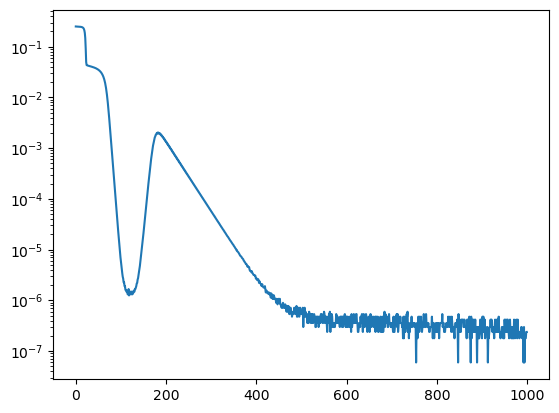

In [21]:
errors = abs((np.array(mlp_loss_data) - np.array(len(mlp_loss_data) * [true_gse])) / true_gse)
plt.plot(mlp_epochs, errors)
plt.yscale('log')
plt.show()

In [22]:
def symmetric_TFIM_expectation_from_torch(nn_output, vars, output_to_psi):
    N, J, Gamma = vars
    dim = 2 ** N
    half_psi = output_to_psi(nn_output)
    psi = torch.cat((half_psi, half_psi.__reversed__()))
    mag2 = torch.norm(psi, 2) ** 2
    # mag = sum(abs(n) ** 2 for n in psi) # make these torch functions, use torch.norm
    phi = torch.zeros(dim, dtype = torch.complex64)
    bra_psi = psi.reshape((1, -1)).conj()
    lib.TFIM_multiply(psi, phi, N, J, Gamma)

    res = (bra_psi @ phi.reshape((-1, 1)))[0][0].real

    return res / mag2

In [23]:
half_input = utils.generate_input_torch(N)[:2 ** (N - 1)]

In [24]:
mlp_model = nn.Sequential(
    nn.Linear(N, 5*N),
    nn.Sigmoid(),
    nn.Linear(5*N, 2),
    nn.Sigmoid()
)

In [25]:
mlp_epochs, mlp_loss_data = lib.train_model_to_gs(mlp_model, 
                      lambda model : model(half_input), 
                      lambda nn_output : symmetric_TFIM_expectation_from_torch(nn_output, (N, J, h), amp_phase), 
                      1000, data_rate = 1)

In [26]:
H = lib.TFIM_hamiltonian(N, J, h)
eigs = H.eigenstates()
true_gse = eigs[0][0]
true_gs = eigs[1][0]
mlp_gse = symmetric_TFIM_expectation_from_torch(mlp_model(half_input), (N, J, h), amp_phase).item()
print('est', mlp_gse)
print('error', abs((mlp_gse - true_gse) / true_gse))
half_gs = amp_phase(mlp_model(half_input))
mlp_gs = torch.cat((half_gs, half_gs.__reversed__()))
mag = np.sqrt(sum(abs(n) ** 2 for n in mlp_gs).detach().numpy() )
mlp_gs = qt.Qobj(mlp_gs.data / mag)
print('fidelity', qt.fidelity(mlp_gs, true_gs))

est -3.999955415725708
error 1.1146068572998047e-05
fidelity 0.9999944648965171


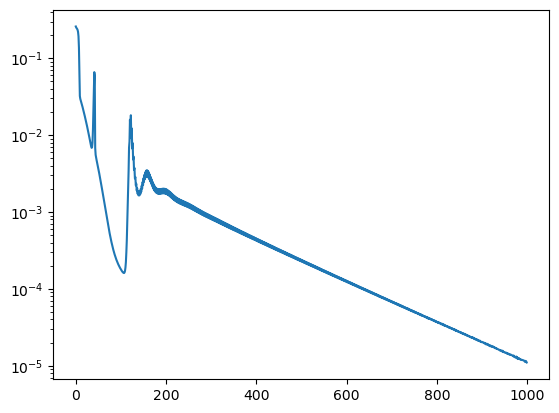

In [27]:
errors = abs((np.array(mlp_loss_data) - np.array(len(mlp_loss_data) * [true_gse])) / true_gse)
plt.plot(mlp_epochs, errors)
plt.yscale('log')
plt.show()

non symmetric results
est -6.46951150894165
error 0.00040549921635941023
fidelity 0.9976869440089331


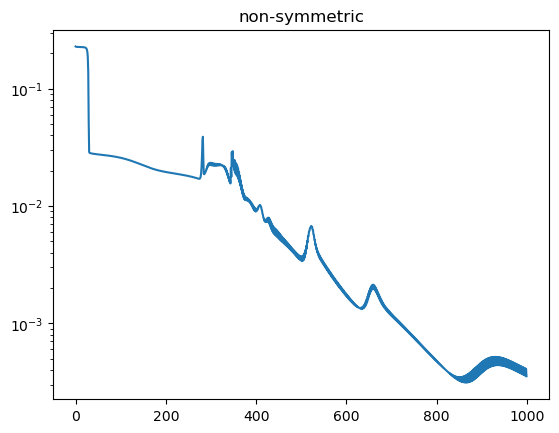

symmetric results
est -6.464710235595703
error 0.0011473367456279963
fidelity 0.9992574396957339


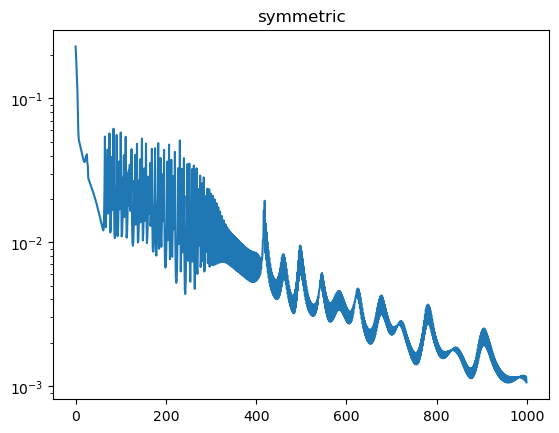

In [29]:
N = 5; J = 1; h = 1
input = utils.generate_input_torch(N)
half_input = input[:2 ** (N - 1)]
mlp_model = nn.Sequential(
    nn.Linear(N, 5*N),
    nn.Sigmoid(),
    nn.Linear(5*N, 2),
    nn.Sigmoid()
)
mlp_epochs, mlp_loss_data = lib.train_model_to_gs(mlp_model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, h), amp_phase), 
                      1000, data_rate = 1)
H = lib.TFIM_hamiltonian(N, J, h)
eigs = H.eigenstates()
true_gse = eigs[0][0]
true_gs = eigs[1][0]
mlp_gse = lib.TFIM_expectation_from_torch(mlp_model(input), (N, J, h), amp_phase).item()
print('non symmetric results')
print('est', mlp_gse)
print('error', abs((mlp_gse - true_gse) / true_gse))
mlp_gs = lib.model_to_ground_state(mlp_model, input, amp_phase)
print('fidelity', qt.fidelity(mlp_gs, true_gs))
errors = abs((np.array(mlp_loss_data) - np.array(len(mlp_loss_data) * [true_gse])) / true_gse)
plt.plot(mlp_epochs, errors)
plt.yscale('log')
plt.title('non-symmetric')
plt.show()

mlp_model = nn.Sequential(
    nn.Linear(N, 5*N),
    nn.Sigmoid(),
    nn.Linear(5*N, 2),
    nn.Sigmoid()
)
mlp_epochs, mlp_loss_data = lib.train_model_to_gs(mlp_model, 
                      lambda model : model(half_input), 
                      lambda nn_output : symmetric_TFIM_expectation_from_torch(nn_output, (N, J, h), amp_phase), 
                      1000, data_rate = 1)
H = lib.TFIM_hamiltonian(N, J, h)
eigs = H.eigenstates()
true_gse = eigs[0][0]
true_gs = eigs[1][0]
mlp_gse = symmetric_TFIM_expectation_from_torch(mlp_model(half_input), (N, J, h), amp_phase).item()
print('symmetric results')
print('est', mlp_gse)
print('error', abs((mlp_gse - true_gse) / true_gse))
half_gs = amp_phase(mlp_model(half_input))
mlp_gs = torch.cat((half_gs, half_gs.__reversed__()))
mag = np.sqrt(sum(abs(n) ** 2 for n in mlp_gs).detach().numpy() )
mlp_gs = qt.Qobj(mlp_gs.data / mag)
print('fidelity', qt.fidelity(mlp_gs, true_gs))
errors = abs((np.array(mlp_loss_data) - np.array(len(mlp_loss_data) * [true_gse])) / true_gse)
plt.plot(mlp_epochs, errors)
plt.yscale('log')
plt.title('symmetric')
plt.show()

non symmetric results
est -10.139734268188477
error 0.010917988230569432
fidelity 0.7484142542996863


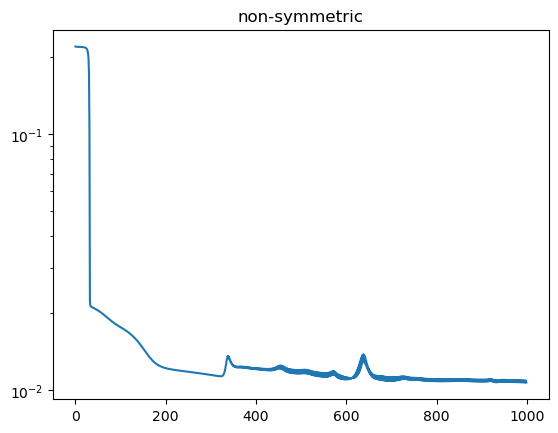

symmetric results
est -10.177421569824219
error 0.00724177432455148
fidelity 0.9854814025104789


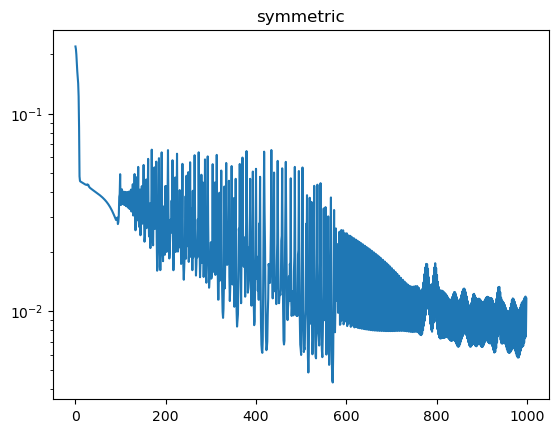

In [31]:
N = 8; J = 1; h = 1
input = utils.generate_input_torch(N)
half_input = input[:2 ** (N - 1)]
mlp_model = nn.Sequential(
    nn.Linear(N, 5*N),
    nn.Sigmoid(),
    nn.Linear(5*N, 2),
    nn.Sigmoid()
)
mlp_epochs, mlp_loss_data = lib.train_model_to_gs(mlp_model, 
                      lambda model : model(input), 
                      lambda nn_output : lib.TFIM_expectation_from_torch(nn_output, (N, J, h), amp_phase), 
                      1000, data_rate = 1)
H = lib.TFIM_hamiltonian(N, J, h)
eigs = H.eigenstates()
true_gse = eigs[0][0]
true_gs = eigs[1][0]
mlp_gse = lib.TFIM_expectation_from_torch(mlp_model(input), (N, J, h), amp_phase).item()
print('non symmetric results')
print('est', mlp_gse)
print('error', abs((mlp_gse - true_gse) / true_gse))
mlp_gs = lib.model_to_ground_state(mlp_model, input, amp_phase)
print('fidelity', qt.fidelity(mlp_gs, true_gs))
errors = abs((np.array(mlp_loss_data) - np.array(len(mlp_loss_data) * [true_gse])) / true_gse)
plt.plot(mlp_epochs, errors)
plt.yscale('log')
plt.title('non-symmetric')
plt.show()

mlp_model = nn.Sequential(
    nn.Linear(N, 5*N),
    nn.Sigmoid(),
    nn.Linear(5*N, 2),
    nn.Sigmoid()
)
mlp_epochs, mlp_loss_data = lib.train_model_to_gs(mlp_model, 
                      lambda model : model(half_input), 
                      lambda nn_output : symmetric_TFIM_expectation_from_torch(nn_output, (N, J, h), amp_phase), 
                      1000, data_rate = 1)
H = lib.TFIM_hamiltonian(N, J, h)
eigs = H.eigenstates()
true_gse = eigs[0][0]
true_gs = eigs[1][0]
mlp_gse = symmetric_TFIM_expectation_from_torch(mlp_model(half_input), (N, J, h), amp_phase).item()
print('symmetric results')
print('est', mlp_gse)
print('error', abs((mlp_gse - true_gse) / true_gse))
half_gs = amp_phase(mlp_model(half_input))
mlp_gs = torch.cat((half_gs, half_gs.__reversed__()))
mag = np.sqrt(sum(abs(n) ** 2 for n in mlp_gs).detach().numpy() )
mlp_gs = qt.Qobj(mlp_gs.data / mag)
print('fidelity', qt.fidelity(mlp_gs, true_gs))
errors = abs((np.array(mlp_loss_data) - np.array(len(mlp_loss_data) * [true_gse])) / true_gse)
plt.plot(mlp_epochs, errors)
plt.yscale('log')
plt.title('symmetric')
plt.show()

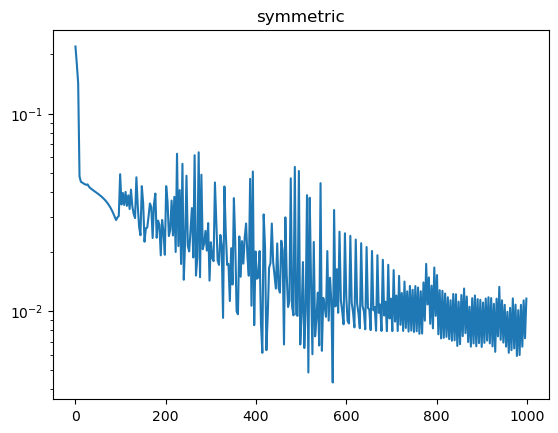

In [35]:
plt.plot(mlp_epochs[::3], errors[::3])
plt.yscale('log')
plt.title('symmetric')
plt.show()